# Introduction to Automatic Hyperparameter Tuning

> Also known as AutoML, Automatic Machine Learning, Meta-optimization, Meta-learning, and so on.

So not only you want to build neural networks and other machine learning algorithms, but also you want to find the best hyperparameters for them automatically. We'll here demonstrate how it's possible with Neuraxle. 

## AutoML loop

The step AutoML is a step that can execute any Automatic Machine Learning Algorithms.

### 1. Define your pipeline

Consider multiple sklearn classifiers that each have their own hyperparms: 

In [1]:
from neuraxle.base import BaseTransformer
from neuraxle.pipeline import Pipeline
from neuraxle.hyperparams.space import HyperparameterSpace
from neuraxle.steps.numpy import NumpyRavel
from neuraxle.steps.output_handlers import OutputTransformerWrapper
from typing import List

# sklearn classifiers, and sklearn wrapper for neuraxle 
from neuraxle.steps.sklearn import SKLearnWrapper
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression

# neuraxle distributions 
from neuraxle.hyperparams.distributions import Choice, RandInt, Boolean, LogUniform

classifiers: List[BaseTransformer] = [
    SKLearnWrapper(DecisionTreeClassifier(), HyperparameterSpace({
            'criterion': Choice(['gini', 'entropy']),
            'splitter': Choice(['best', 'random']),
            'min_samples_leaf': RandInt(2, 5),
            'min_samples_split': RandInt(1, 3)
        })).set_name('DecisionTreeClassifier'),
    Pipeline([
            OutputTransformerWrapper(NumpyRavel()),
            SKLearnWrapper(RidgeClassifier(), HyperparameterSpace({
                'alpha': Choice([(0.0, 1.0, 10.0), (0.0, 10.0, 100.0)]),
                'fit_intercept': Boolean(),
                'normalize': Boolean()
    }))
    ]).set_name('RidgeClassifier'),
    Pipeline([
        OutputTransformerWrapper(NumpyRavel()),
        SKLearnWrapper(LogisticRegression(), HyperparameterSpace({
            'C': LogUniform(0.01, 10.0),
            'fit_intercept': Boolean(),
            'dual': Boolean(),
            'penalty': Choice(['l1', 'l2']),
            'max_iter': RandInt(20, 200)
        }))
    ]).set_name('LogisticRegression')
]

Consider a pipeline that chooses one of those classifiers based on its hyperparams: 

In [2]:
from neuraxle.steps.flow import ChooseOneStepOf

p: Pipeline = Pipeline([
    ChooseOneStepOf(classifiers)
])

### 2. Choose a validation splitter

Let's pick the [ValidationSplitter](https://www.neuraxle.org/stable/api/neuraxle.metaopt.auto_ml.html?highlight=validationsplitter#neuraxle.metaopt.auto_ml.ValidationSplitter) which is enough for most machine learning problems:

In [3]:
from neuraxle.metaopt.auto_ml import ValidationSplitter

validation_splitter = ValidationSplitter(test_size=0.20)

This validation splitter will split the train, and test set with 80% train, and 20% validation.

We have also implemented [KFoldCrossValidationSplitter](https://www.neuraxle.org/stable/api/neuraxle.metaopt.auto_ml.html?highlight=kfoldcross#neuraxle.metaopt.auto_ml.KFoldCrossValidationSplitter) if you are interested in using cross-validation for your machine learning problem.

### 3. Define a the main scoring metric with [ScoringCallback](https://www.neuraxle.org/stable/api/neuraxle.metaopt.callbacks.html?highlight=scoringcallback#neuraxle.metaopt.callbacks.ScoringCallback)

Let's pick the accuracy score as our scoring metric: 

In [5]:
from neuraxle.metaopt.callbacks import ScoringCallback
from sklearn.metrics import accuracy_score


scoring_callback = ScoringCallback(
    metric_function=accuracy_score, 
    name='accuracy', 
    higher_score_is_better=True,
    print_metrics=False
)

### 4. Add metric callbacks with [MetricCallback](https://www.neuraxle.org/stable/api/neuraxle.metaopt.callbacks.html?highlight=metriccallback#neuraxle.metaopt.callbacks.MetricCallback) (optional)

Let's add sklearn f1_score as an additional metric callback: 

In [6]:
from sklearn.metrics import mean_absolute_error
from neuraxle.metaopt.callbacks import MetricCallback
from sklearn.metrics import f1_score, precision_score, recall_score

callbacks = [
    MetricCallback('f1', metric_function=f1_score, higher_score_is_better=True, print_metrics=False),
    MetricCallback('precision', metric_function=precision_score, higher_score_is_better=True, print_metrics=False),
    MetricCallback('recall', metric_function=recall_score, higher_score_is_better=True, print_metrics=False)
]

You could also implement your own callback for things such as EarlyStopping if you want too. You need to create a callback that inherits from [BaseCallback](https://www.neuraxle.org/stable/api/neuraxle.metaopt.callbacks.html?highlight=basecallback#neuraxle.metaopt.callbacks.BaseCallback).

### 5. Select an hyperparams repository 

For the sake of this example, let's pick the [InMemoryHyperparamsRepository](https://www.neuraxle.org/stable/api/neuraxle.metaopt.auto_ml.html?highlight=inmemoryhyperparamsrepository#neuraxle.metaopt.auto_ml.InMemoryHyperparamsRepository) because we don't need to persist trial files:

In [7]:
from neuraxle.metaopt.auto_ml import InMemoryHyperparamsRepository

hyperparams_repository = InMemoryHyperparamsRepository(cache_folder='cache')

[HyperparamsJSONRepository](https://www.neuraxle.org/stable/api/neuraxle.metaopt.auto_ml.html?highlight=hyperparamsjsonrepository#neuraxle.metaopt.auto_ml.HyperparamsJSONRepository)​ is also available if you want to use json files to persist trials.

Subscribe to the hyperparams if you want to plot results as they come, or on completion (experimental).

In [8]:
from neuraxle.plotting import TrialMetricsPlottingObserver

hyperparams_repository.subscribe(TrialMetricsPlottingObserver(
    plotting_folder_name='metric_results', 
    save_plots=False, 
    plot_trial_on_next=False,
    plot_all_trials_on_complete=True,
    plot_individual_trials_on_complete=False
))

### 6. Select an hyperparams optimizer 

Let's pick the infamous Tree Parzen Estimator algorithm:

In [9]:
from neuraxle.metaopt.tpe import TreeParzenEstimatorHyperparameterSelectionStrategy

hyperparams_optimizer = TreeParzenEstimatorHyperparameterSelectionStrategy(
    number_of_initial_random_step=10,
    quantile_threshold=0.3,
    number_good_trials_max_cap=25,
    number_possible_hyperparams_candidates=100,
    prior_weight=0.,
    use_linear_forgetting_weights=False,
    number_recent_trial_at_full_weights=25
)

Note: as of now, [TreeParzenEstimatorHyperparameterSelectionStrategy](https://www.neuraxle.org/stable/api/neuraxle.metaopt.tpe.html#neuraxle.metaopt.tpe.TreeParzenEstimatorHyperparameterSelectionStrategy) is the first usable Apache 2 public TPE implementation ! Thanks to Éric Hamel for implementing this amazing algorithm. 

Also note that if you don't define the hyperparams_optimizer, [RandomSearchHyperparameterSelectionStrategy](https://www.neuraxle.org/stable/api/neuraxle.metaopt.auto_ml.html?highlight=randomsearchhyperparam#neuraxle.metaopt.auto_ml.RandomSearchHyperparameterSelectionStrategy) will be used by default.

### 7. Create, and launch AutoML loop

Create the AutoML step that will execute the training loop:

In [10]:
from neuraxle.metaopt.auto_ml import AutoML
import os

tmpdir = 'cache'
if not os.path.exists(tmpdir):
    os.makedirs(tmpdir)
    
n_trials = 10
n_epochs = 10
    
auto_ml = AutoML(
    pipeline=p,
    validation_splitter=validation_splitter,
    refit_trial=True,
    n_trials=n_trials,
    epochs=n_epochs,
    cache_folder_when_no_handle=str(tmpdir),
    scoring_callback=scoring_callback,
    callbacks=callbacks,
    hyperparams_repository=hyperparams_repository
)

## Run 10 trials 

new trial:
{
    "ChooseOneStepOf": {
        "choice": "DecisionTreeClassifier"
    }
}

trial 1/10
fitting trial 1/10 split 1/1
hyperparams: {
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__ccp_alpha": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__class_weight": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__criterion": "gini",
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_depth": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_features": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_leaf_nodes": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_decrease": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_split": null,
    "ChooseOneStepOf__DecisionTreeClass

success trial 1/10 split 1/1
hyperparams: {
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__ccp_alpha": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__class_weight": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__criterion": "gini",
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_depth": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_features": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_leaf_nodes": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_decrease": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_split": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_samples_leaf": 1,
    "ChooseOneStepOf__DecisionTreeClas


epoch 3/10

epoch 4/10

epoch 5/10

epoch 6/10

epoch 7/10

epoch 8/10

epoch 9/10

epoch 10/10
success trial 2/10 split 1/1
hyperparams: {
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__ccp_alpha": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__class_weight": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__criterion": "gini",
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_depth": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_features": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_leaf_nodes": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_decrease": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_split": null,
    "ChooseOneStepOf__DecisionTreeClassifie


epoch 3/10

epoch 4/10

epoch 5/10

epoch 6/10

epoch 7/10

epoch 8/10

epoch 9/10

epoch 10/10
success trial 3/10 split 1/1
hyperparams: {
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__ccp_alpha": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__class_weight": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__criterion": "gini",
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_depth": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_features": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_leaf_nodes": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_decrease": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_split": null,
    "ChooseOneStepOf__DecisionTreeClassifie


epoch 3/10

epoch 4/10

epoch 5/10

epoch 6/10

epoch 7/10

epoch 8/10

epoch 9/10

epoch 10/10
success trial 4/10 split 1/1
hyperparams: {
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__ccp_alpha": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__class_weight": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__criterion": "gini",
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_depth": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_features": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_leaf_nodes": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_decrease": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_split": null,
    "ChooseOneStepOf__DecisionTreeClassifie


epoch 3/10

epoch 4/10

epoch 5/10

epoch 6/10

epoch 7/10

epoch 8/10

epoch 9/10

epoch 10/10
success trial 5/10 split 1/1
hyperparams: {
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__ccp_alpha": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__class_weight": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__criterion": "gini",
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_depth": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_features": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_leaf_nodes": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_decrease": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_split": null,
    "ChooseOneStepOf__DecisionTreeClassifie


epoch 2/10

epoch 3/10

epoch 4/10

epoch 5/10

epoch 6/10

epoch 7/10

epoch 8/10

epoch 9/10

epoch 10/10
success trial 6/10 split 1/1
hyperparams: {
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__ccp_alpha": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__class_weight": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__criterion": "gini",
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_depth": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_features": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_leaf_nodes": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_decrease": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_split": null,
    "ChooseOneStepOf__DecisionT


epoch 3/10

epoch 4/10

epoch 5/10

epoch 6/10

epoch 7/10

epoch 8/10

epoch 9/10

epoch 10/10
success trial 7/10 split 1/1
hyperparams: {
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__ccp_alpha": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__class_weight": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__criterion": "gini",
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_depth": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_features": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_leaf_nodes": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_decrease": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_split": null,
    "ChooseOneStepOf__DecisionTreeClassifie


epoch 3/10

epoch 4/10

epoch 5/10

epoch 6/10

epoch 7/10

epoch 8/10

epoch 9/10

epoch 10/10
success trial 8/10 split 1/1
hyperparams: {
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__ccp_alpha": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__class_weight": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__criterion": "gini",
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_depth": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_features": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_leaf_nodes": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_decrease": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_split": null,
    "ChooseOneStepOf__DecisionTreeClassifie


epoch 3/10

epoch 4/10

epoch 5/10

epoch 6/10

epoch 7/10

epoch 8/10

epoch 9/10

epoch 10/10
success trial 9/10 split 1/1
hyperparams: {
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__ccp_alpha": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__class_weight": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__criterion": "gini",
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_depth": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_features": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_leaf_nodes": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_decrease": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_split": null,
    "ChooseOneStepOf__DecisionTreeClassifie


epoch 3/10

epoch 4/10

epoch 5/10

epoch 6/10

epoch 7/10

epoch 8/10

epoch 9/10

epoch 10/10
success trial 10/10 split 1/1
hyperparams: {
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__ccp_alpha": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__class_weight": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__criterion": "gini",
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_depth": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_features": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__max_leaf_nodes": null,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_decrease": 0.0,
    "ChooseOneStepOf__DecisionTreeClassifier__Optional(DecisionTreeClassifier)__min_impurity_split": null,
    "ChooseOneStepOf__DecisionTreeClassifi

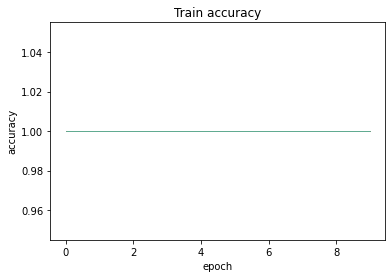

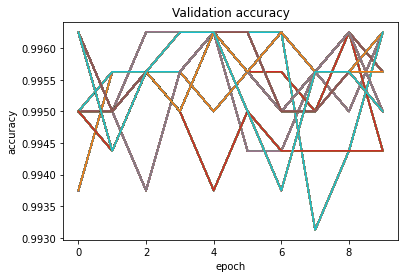

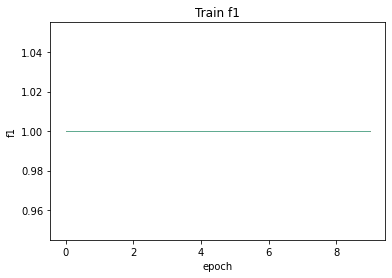

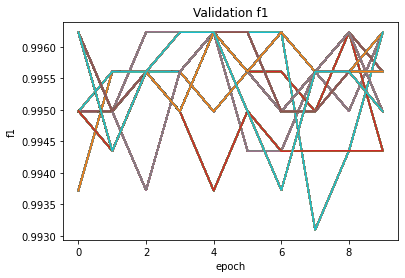

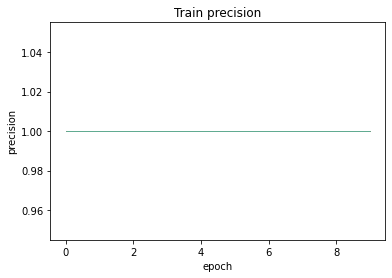

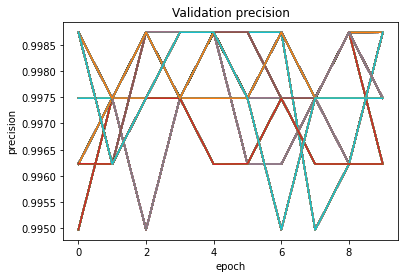

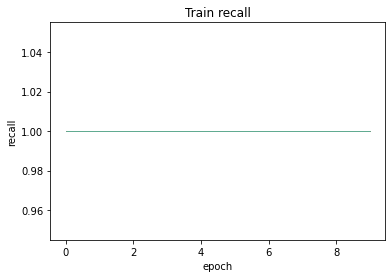

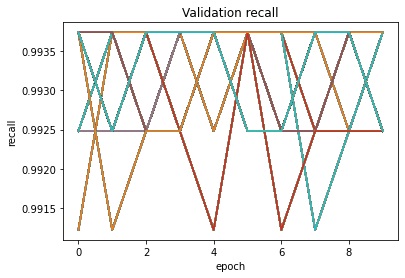

best hyperparams:
{
    "ChooseOneStepOf": {
        "DecisionTreeClassifier": {
            "Optional(DecisionTreeClassifier)": {
                "ccp_alpha": 0.0,
                "class_weight": null,
                "criterion": "gini",
                "max_depth": null,
                "max_features": null,
                "max_leaf_nodes": null,
                "min_impurity_decrease": 0.0,
                "min_impurity_split": null,
                "min_samples_leaf": 1,
                "min_samples_split": 2,
                "min_weight_fraction_leaf": 0.0,
                "presort": "deprecated",
                "random_state": null,
                "splitter": "best"
            },
            "enabled": true
        },
        "LogisticRegression": {
            "Optional(LogisticRegression)": {
                "SKLearnWrapper_LogisticRegression": {
                    "C": 1.0,
                    "class_weight": null,
                    "dual": false,
                    "

In [11]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import shutil

def generate_classification_data():
    data_inputs, expected_outputs = make_classification(
        n_samples=10000,
        n_repeated=0,
        n_classes=3,
        n_features=4,
        n_clusters_per_class=1,
        class_sep=1.5,
        flip_y=0,
        weights=[0.5, 0.5, 0.5]
    )

    X_train, X_test, y_train, y_test = train_test_split(
        data_inputs,
        expected_outputs,
        test_size=0.20
    )

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = generate_classification_data()
auto_ml = auto_ml.fit(X_train, y_train)

## Get best model, and predict

Test accuracy score: 0.995
